In [102]:
from sklearn.cluster import SpectralCoclustering
from matplotlib import colormaps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import matplotlib.colors as mcolors

import pandas as pd

original_df1 = pd.read_excel('Good Samaritan Overdose Prevention Laws Data 8.25.2023.xlsx')

original_df1.replace(0, 0.0001, inplace=True)
original_df1 = original_df1.fillna(0.0001)
original_df1.replace('.', 0.0001, inplace=True)
original_df1 = original_df1.groupby('Jurisdictions', as_index=False).last()
original_df1 = original_df1.drop(columns=['Effective Date', 'Valid Through Date'])
print(original_df1.dtypes)
original_df1.head()

# Transpose the DataFrame
og_transposed_df = original_df1.set_index('Jurisdictions').T

# og_transposed_df = og_transposed_df.iloc[:len(og_transposed_df)//2, :len(og_transposed_df.columns)//2]
og_transposed_df = og_transposed_df.iloc[:len(og_transposed_df)//2, :len(og_transposed_df.columns)//2]
og_transposed_df = og_transposed_df.iloc[:len(og_transposed_df.columns)//2]

# Load the states.csv file into a DataFrame
states_df = pd.read_csv('states.csv')

# Create a dictionary mapping state names to abbreviations
state_to_abbr = dict(zip(states_df['State'], states_df['Abbreviation']))

# Map state names to abbreviations in transposed_df
og_transposed_df.columns = og_transposed_df.columns.map(state_to_abbr.get)

# Perform Spectral Co-clustering
model = SpectralCoclustering(n_clusters=5, random_state=0)
model.fit(og_transposed_df)

fit_data = og_transposed_df.iloc[np.argsort(model.row_labels_)]
fit_data = fit_data.iloc[:, np.argsort(model.column_labels_)]

sorted_row_indices = np.argsort(model.row_labels_)  # model.row labels [2 0 2 2 2 1 2 0 0 0 2]
sorted_col_indices = np.argsort(model.column_labels_)

Jurisdictions                                                                                   object
goodsam-law                                                                                    float64
goodsam-cs_Arrest                                                                              float64
goodsam-cs_Charge                                                                              float64
goodsam-cs_Prosecution                                                                         float64
goodsam-cs_Law provides an affirmative defense                                                 float64
goodsam-cs_Law provides other procedural protections                                           float64
goodsam-cs_None                                                                                float64
goodsam-paraphernalia_Arrest                                                                   float64
goodsam-paraphernalia_Charge                                             

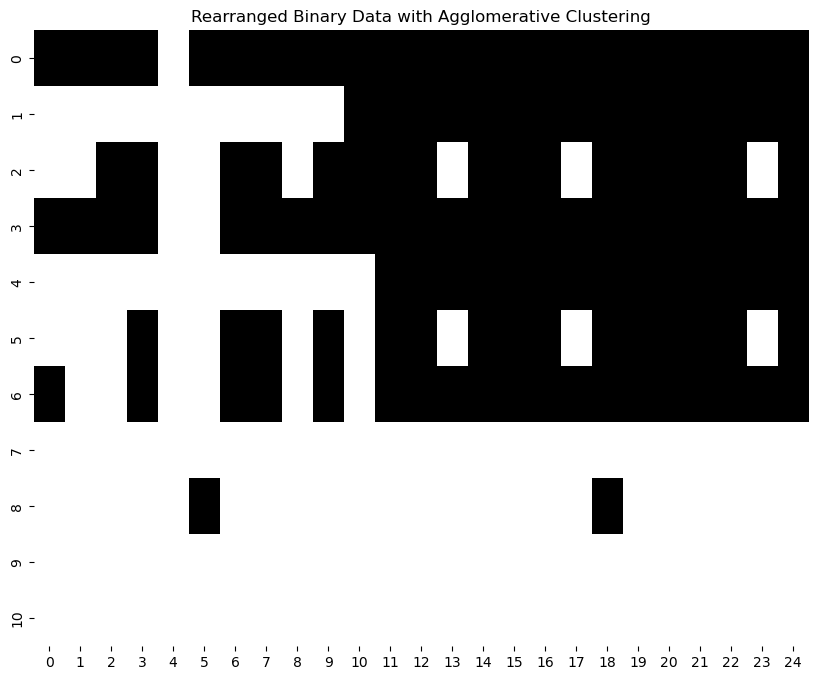

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


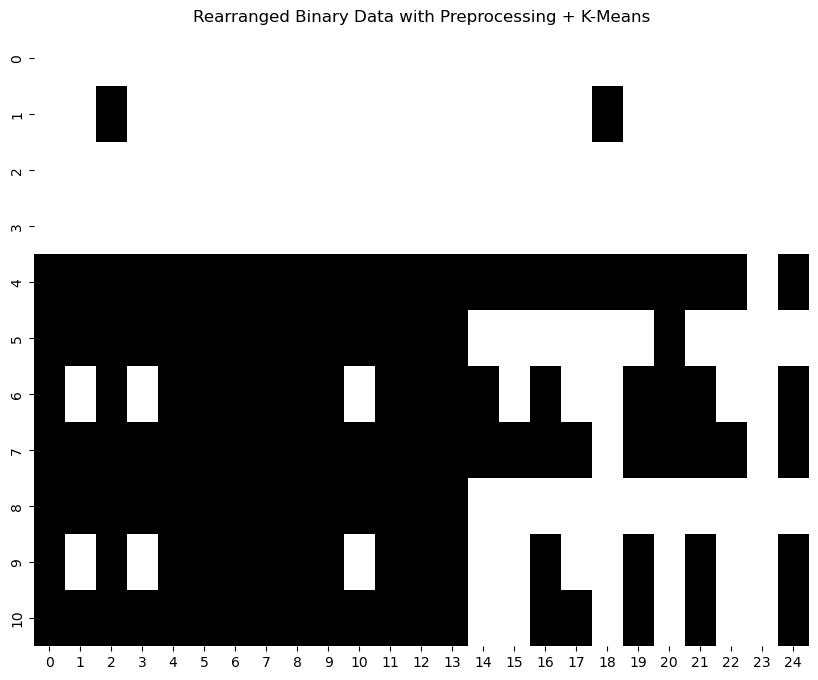

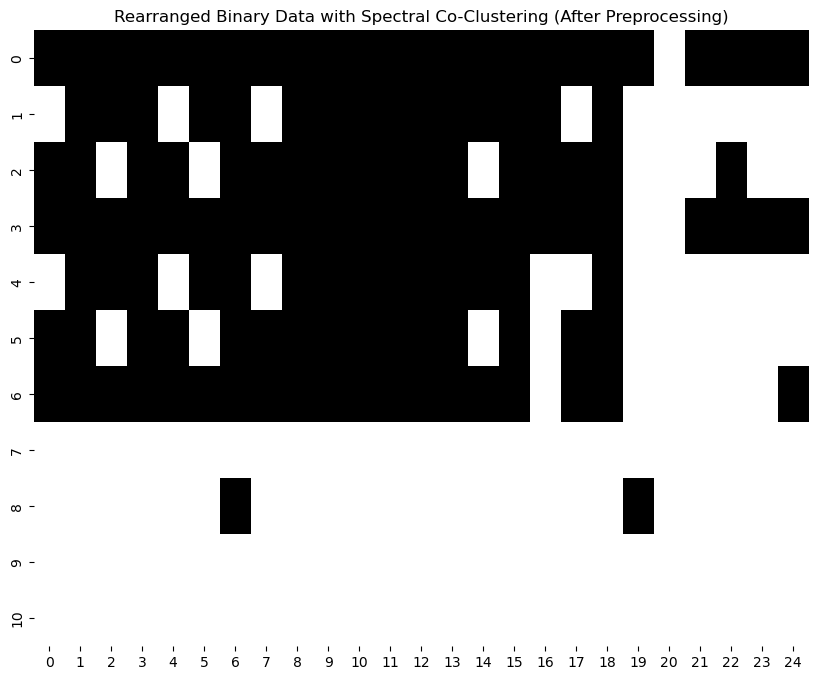

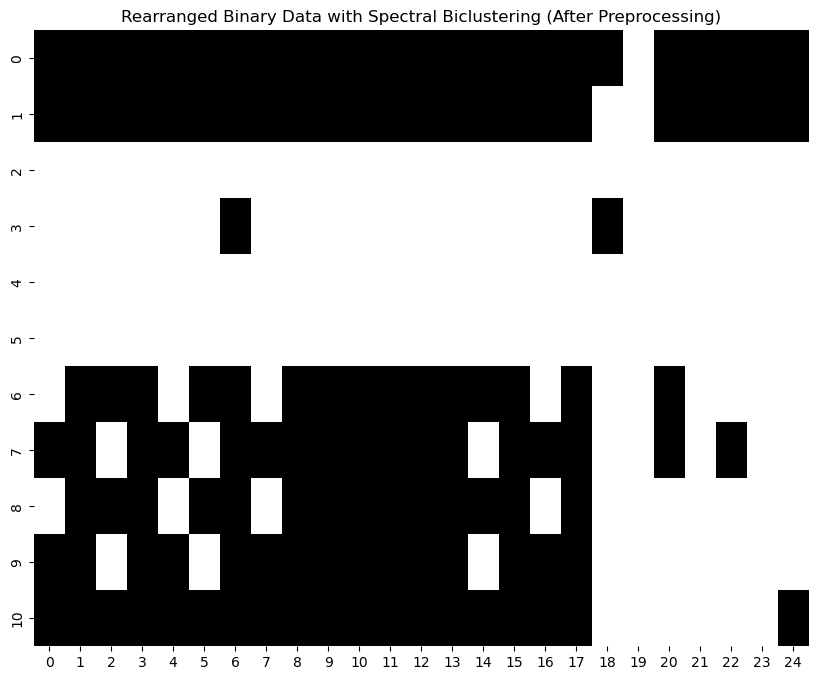

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralCoclustering, KMeans
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralBiclustering


df_new=og_transposed_df.copy()
data=df_new.values
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data)

# Step 2: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 principal components, you can adjust as needed
reduced_data = pca.fit_transform(normalized_data)
reduced_data_t=pca.fit_transform(normalized_data.T)
from sklearn.cluster import AgglomerativeClustering

# Perform agglomerative clustering for rows and columns separately
row_clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward').fit(reduced_data)
column_clustering = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward').fit(reduced_data_t)

# Sort the rows and columns based on the clustering labels
sorted_row_idx = np.argsort(row_clustering.labels_)
sorted_col_idx = np.argsort(column_clustering.labels_)

# Rearrange the rows and columns in the data matrix
sorted_data_aglo = data[sorted_row_idx, :]
sorted_data_aglo = sorted_data_aglo[:, sorted_col_idx]

# Visualize the sorted binary matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_data_aglo, cmap='Greys', cbar=False)
plt.title('Rearranged Binary Data with Agglomerative Clustering')
plt.show()


# Step 3: Apply K-Means clustering
# Clustering the rows based on the reduced data
kmeans_row = KMeans(n_clusters=2, random_state=42).fit(reduced_data)
row_labels = kmeans_row.labels_

# Clustering the columns based on normalized data
kmeans_column = KMeans(n_clusters=2, random_state=42).fit(reduced_data_t)
column_labels = kmeans_column.labels_

# Step 4: Rearrange the matrix based on the cluster labels
sorted_row_idx = np.argsort(row_labels)
sorted_col_idx = np.argsort(column_labels)

sorted_data_kmeans = data[sorted_row_idx, :]
sorted_data_kmeans = sorted_data_kmeans[:, sorted_col_idx]

# Step 5: Visualize the rearranged binary data
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_data_kmeans, cmap='Greys', cbar=False)
plt.title('Rearranged Binary Data with Preprocessing + K-Means')
plt.show()

cocluster_model = SpectralCoclustering(n_clusters=2, random_state=42)
cocluster_model.fit(normalized_data)

# Get the row and column labels from the co-clustering
row_labels = cocluster_model.row_labels_
column_labels = cocluster_model.column_labels_

# Step 4: Rearrange the rows and columns in the original binary data based on clustering
sorted_row_idx = np.argsort(row_labels)
sorted_col_idx = np.argsort(column_labels)

sorted_data_cocluster = data[sorted_row_idx, :]
sorted_data_cocluster = sorted_data_cocluster[:, sorted_col_idx]

# Step 5: Visualize the rearranged data as a binary heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_data_cocluster, cmap='Greys', cbar=False)
plt.title('Rearranged Binary Data with Spectral Co-Clustering (After Preprocessing)')
plt.show()


bicluster_model = SpectralBiclustering(n_clusters=2, method='log', random_state=42)
bicluster_model.fit(normalized_data)

# Get the row and column labels from the biclustering
row_labels_bicluster = bicluster_model.row_labels_
column_labels_bicluster = bicluster_model.column_labels_

# Step 4: Rearrange the rows and columns in the original binary data based on biclustering
sorted_row_idx_bicluster = np.argsort(row_labels_bicluster)
sorted_col_idx_bicluster = np.argsort(column_labels_bicluster)

sorted_data_bicluster = data[sorted_row_idx_bicluster, :]
sorted_data_bicluster = sorted_data_bicluster[:, sorted_col_idx_bicluster]

# Step 5: Visualize the rearranged binary data as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_data_bicluster, cmap='Greys', cbar=False)
plt.title('Rearranged Binary Data with Spectral Biclustering (After Preprocessing)')
plt.show()

In [5]:
def rearrange_rows_by_ones(matrix):
    """
    Rearrange the rows of a binary matrix such that rows with more 1's are placed near each other.

    Args:
    matrix (ndarray): A 2D binary numpy array (0's and 1's).

    Returns:
    sorted_matrix (ndarray): The rearranged binary matrix.
    """

    # Step 1: Compute the sum of 1's in each row
    row_sums = np.sum(matrix, axis=1)  # Sum of 1's per row

    # Step 2: Sort rows based on the sum of 1's (descending order)
    sorted_row_idx_by_ones = np.argsort(-row_sums)  # Sort in descending order (more 1's first)

    # Step 3: Rearrange the matrix rows based on this sorting
    sorted_matrix = matrix[sorted_row_idx_by_ones, :]

    # Step 4: Visualize the rearranged matrix where rows with more 1's are closer
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_matrix, cmap='Greys', cbar=False)
    plt.title('Binary Data Rearranged by Row Sums of 1\'s')
    plt.show()

    return sorted_matrix

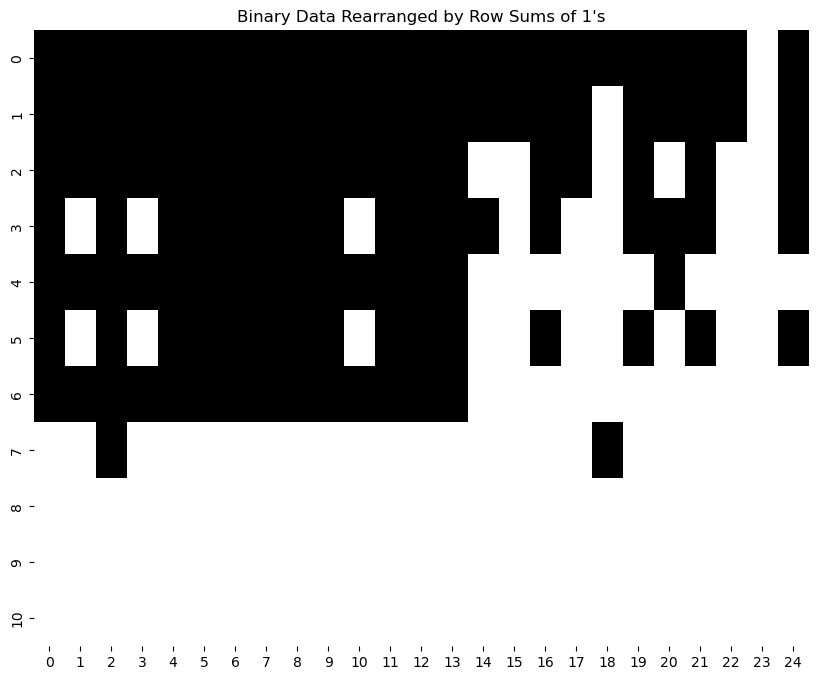

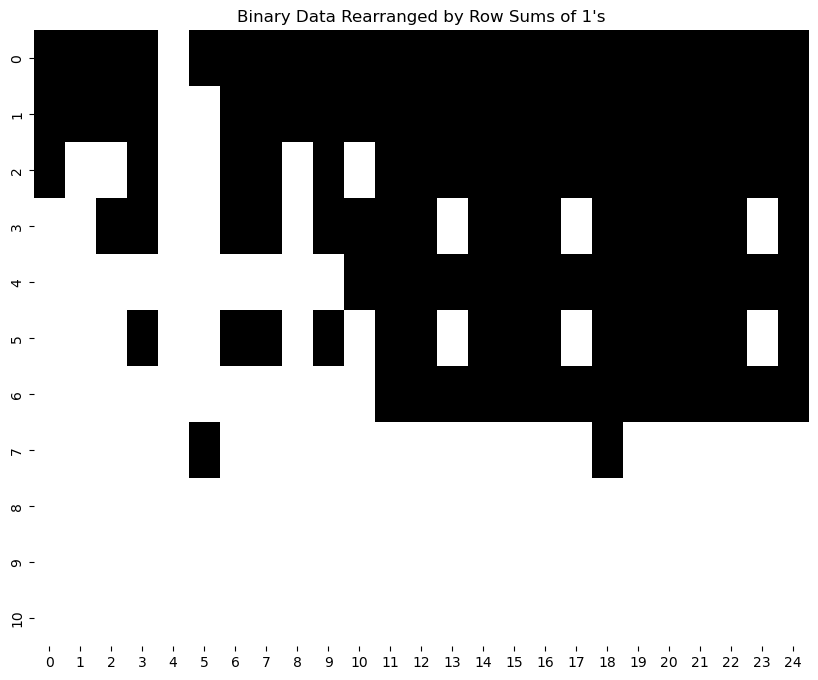

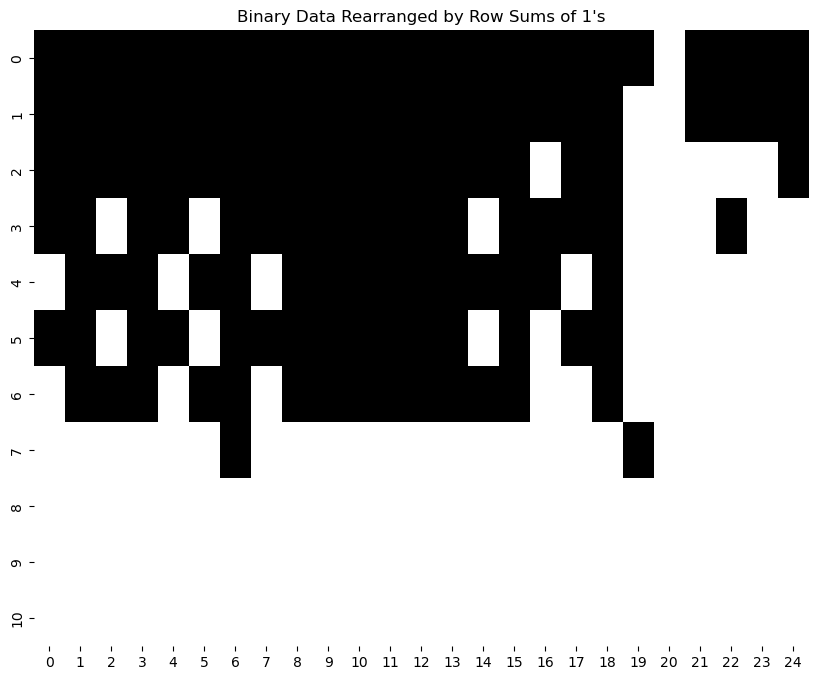

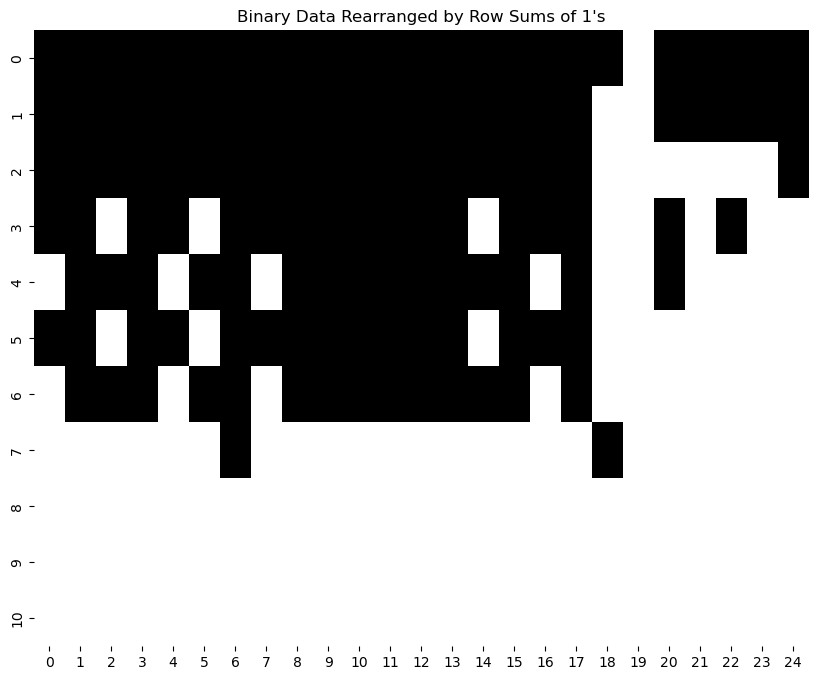

In [7]:
sorted_data_kmeans=rearrange_rows_by_ones(sorted_data_kmeans)
sorted_data_aglo = rearrange_rows_by_ones(sorted_data_aglo)
sorted_data_cocluster= rearrange_rows_by_ones(sorted_data_cocluster)
sorted_data_bicluster=rearrange_rows_by_ones(sorted_data_bicluster)

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def rearrange_matrix_by_ones(matrix):

    # Step 1: Compute the sum of 1's in each row
    row_sums = np.sum(matrix, axis=1)  # Sum of 1's per row

    # Step 2: Sort rows based on the sum of 1's (descending order)
    sorted_row_idx_by_ones = np.argsort(-row_sums)  # Sort in descending order (more 1's first)

    # Step 3: Rearrange the matrix rows based on this sorting
    sorted_matrix = matrix[sorted_row_idx_by_ones, :]

    # Step 4: Compute the sum of 1's in each column of the sorted matrix
    col_sums = np.sum(sorted_matrix, axis=0)  # Sum of 1's per column

    # Step 5: Sort columns based on the sum of 1's (descending order)
    sorted_col_idx_by_ones = np.argsort(-col_sums)  # Sort in descending order (more 1's first)

    # Step 6: Rearrange the sorted matrix columns based on this sorting
    sorted_matrix = sorted_matrix[:, sorted_col_idx_by_ones]

    # Step 7: Visualize the rearranged matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(sorted_matrix, cmap='Greys', cbar=False)
    plt.title('Binary Data Rearranged by Row and Column Sums of 1\'s')
    plt.show()

    return sorted_matrix

# Example usage:
# matrix = np.array([[0, 1, 0, 1], [1, 1, 1, 0], [0, 0, 0, 1], [1, 1, 1, 1]])
# sorted_matrix = rearrange_matrix_by_ones(matrix)


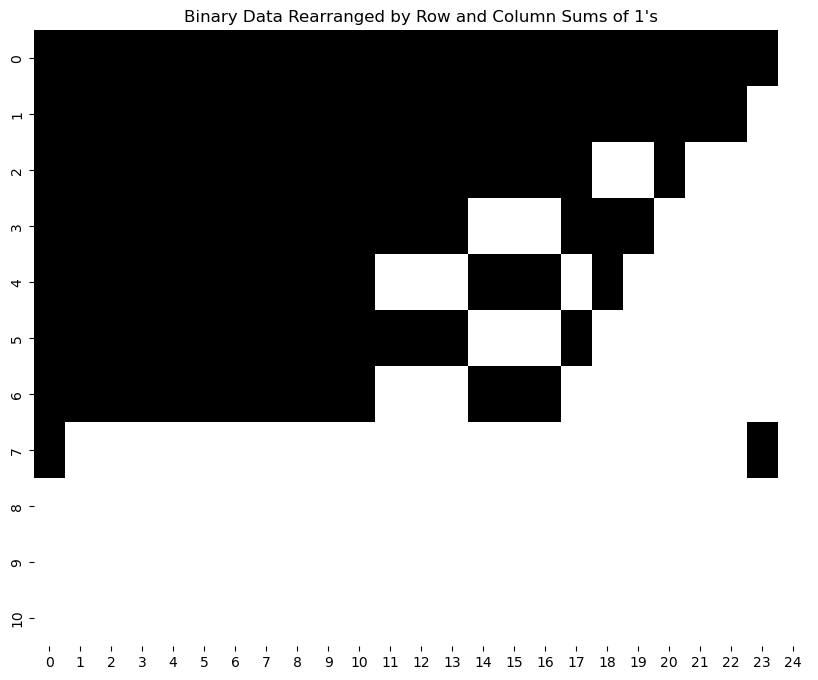

In [11]:
sorted_data=rearrange_matrix_by_ones(sorted_data_kmeans)

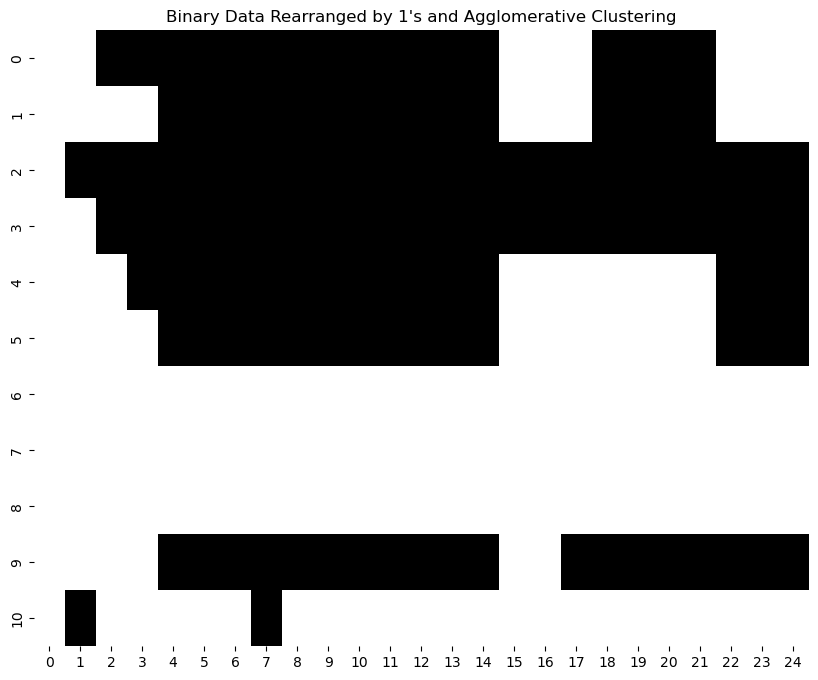

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

def rearrange_matrix_by_ones_and_clustering(matrix, n_clusters=2):

    # Step 1: Compute the sum of 1's in each row
    row_sums = np.sum(matrix, axis=1)  # Sum of 1's per row

    # Step 2: Sort rows based on the sum of 1's (descending order)
    sorted_row_idx_by_ones = np.argsort(-row_sums)  # Sort in descending order (more 1's first)

    # Step 3: Rearrange the matrix rows based on this sorting
    sorted_matrix = matrix[sorted_row_idx_by_ones, :]

    # Step 4: Compute the sum of 1's in each column of the sorted matrix
    col_sums = np.sum(sorted_matrix, axis=0)  # Sum of 1's per column

    # Step 5: Sort columns based on the sum of 1's (descending order)
    sorted_col_idx_by_ones = np.argsort(-col_sums)  # Sort in descending order (more 1's first)

    # Step 6: Rearrange the sorted matrix columns based on this sorting
    sorted_matrix = sorted_matrix[:, sorted_col_idx_by_ones]

    # Step 7: Apply agglomerative clustering on the rows
    row_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='jaccard', linkage='complete').fit(sorted_matrix)
    sorted_row_idx_by_clustering = np.argsort(row_clustering.labels_)
    clustered_matrix = sorted_matrix[sorted_row_idx_by_clustering, :]

    # Step 8: Apply agglomerative clustering on the columns (transpose to cluster columns as rows)
    col_clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='jaccard', linkage='complete').fit(clustered_matrix.T)
    sorted_col_idx_by_clustering = np.argsort(col_clustering.labels_)
    clustered_matrix = clustered_matrix[:, sorted_col_idx_by_clustering]

    # Step 9: Visualize the rearranged matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(clustered_matrix, cmap='Greys', cbar=False)
    plt.title('Binary Data Rearranged by 1\'s and Agglomerative Clustering')
    plt.show()

    # return clustered_matrix

# Example usage:
# matrix = np.array([[0, 1, 0, 1], [1, 1, 1, 0], [0, 0, 0, 1], [1, 1, 1, 1]])
# clustered_matrix = rearrange_matrix_by_ones_and_clustering(matrix)

rearrange_matrix_by_ones_and_clustering(sorted_data_kmeans, 6)


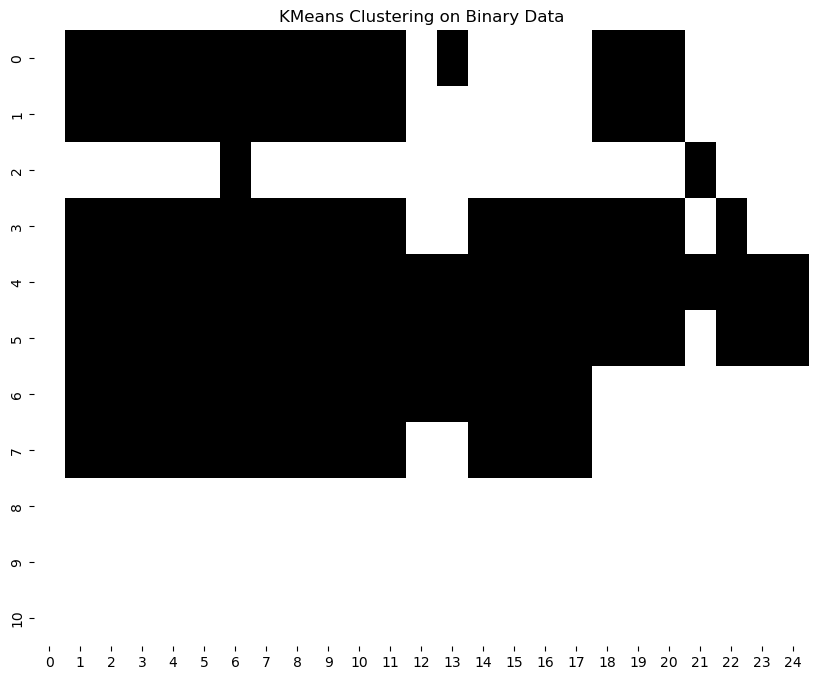

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def rearrange_matrix_by_ones_and_kmeans(matrix, n_clusters=2):

    # Step 1: Compute the sum of 1's in each row
    row_sums = np.sum(matrix, axis=1)

    # Step 2: Sort rows based on the sum of 1's
    sorted_row_idx_by_ones = np.argsort(-row_sums)
    sorted_matrix = matrix[sorted_row_idx_by_ones, :]

    # Step 3: Sort columns based on the sum of 1's
    col_sums = np.sum(sorted_matrix, axis=0)
    sorted_col_idx_by_ones = np.argsort(-col_sums)
    sorted_matrix = sorted_matrix[:, sorted_col_idx_by_ones]

    # Step 4: Apply KMeans clustering on the rows (set n_init explicitly)
    row_clustering = KMeans(n_clusters=n_clusters, n_init=10).fit(sorted_matrix)
    sorted_row_idx_by_clustering = np.argsort(row_clustering.labels_)
    clustered_matrix = sorted_matrix[sorted_row_idx_by_clustering, :]

    # Step 5: Apply KMeans clustering on the columns (set n_init explicitly)
    col_clustering = KMeans(n_clusters=n_clusters, n_init=10).fit(clustered_matrix.T)
    sorted_col_idx_by_clustering = np.argsort(col_clustering.labels_)
    clustered_matrix = clustered_matrix[:, sorted_col_idx_by_clustering]

    # Visualize the rearranged matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(clustered_matrix, cmap='Greys', cbar=False)
    plt.title('KMeans Clustering on Binary Data')
    plt.show()

# Example usage
rearrange_matrix_by_ones_and_kmeans(sorted_data_kmeans, 6)


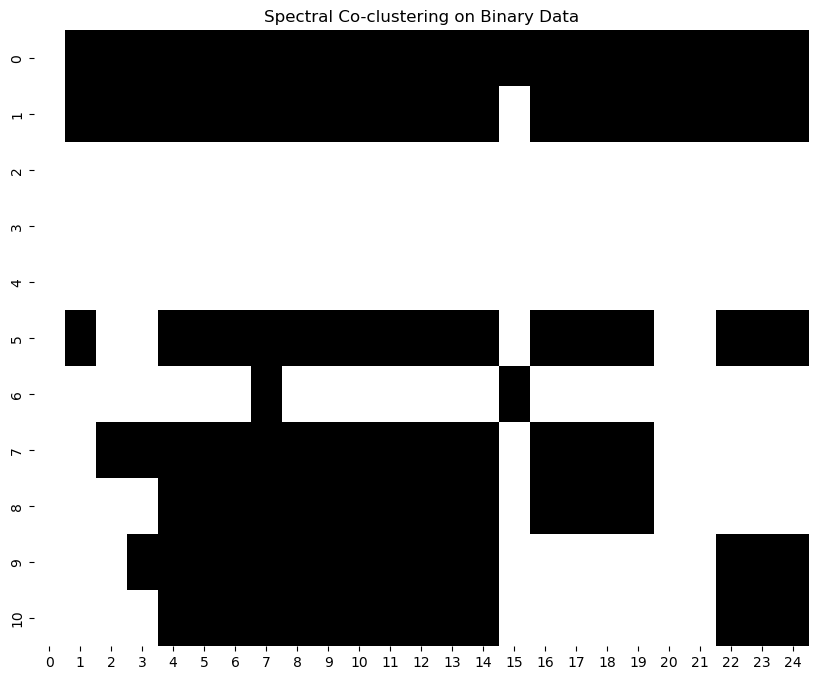

In [19]:
from sklearn.cluster import SpectralCoclustering

def rearrange_matrix_by_spectral_co_clustering(matrix, n_clusters=2):

    # Step 1: Compute the sum of 1's in each row
    row_sums = np.sum(matrix, axis=1)
    sorted_row_idx_by_ones = np.argsort(-row_sums)
    sorted_matrix = matrix[sorted_row_idx_by_ones, :]

    # Step 2: Sort columns based on the sum of 1's
    col_sums = np.sum(sorted_matrix, axis=0)
    sorted_col_idx_by_ones = np.argsort(-col_sums)
    sorted_matrix = sorted_matrix[:, sorted_col_idx_by_ones]

    # Step 3: Apply Spectral Co-clustering
    co_clustering = SpectralCoclustering(n_clusters=n_clusters, random_state=0).fit(sorted_matrix)
    sorted_row_idx_by_clustering = np.argsort(co_clustering.row_labels_)
    clustered_matrix = sorted_matrix[sorted_row_idx_by_clustering, :]

    sorted_col_idx_by_clustering = np.argsort(co_clustering.column_labels_)
    clustered_matrix = clustered_matrix[:, sorted_col_idx_by_clustering]

    # Visualize the rearranged matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(clustered_matrix, cmap='Greys', cbar=False)
    plt.title('Spectral Co-clustering on Binary Data')
    plt.show()

# Example usage
rearrange_matrix_by_spectral_co_clustering(sorted_data_kmeans, 6)


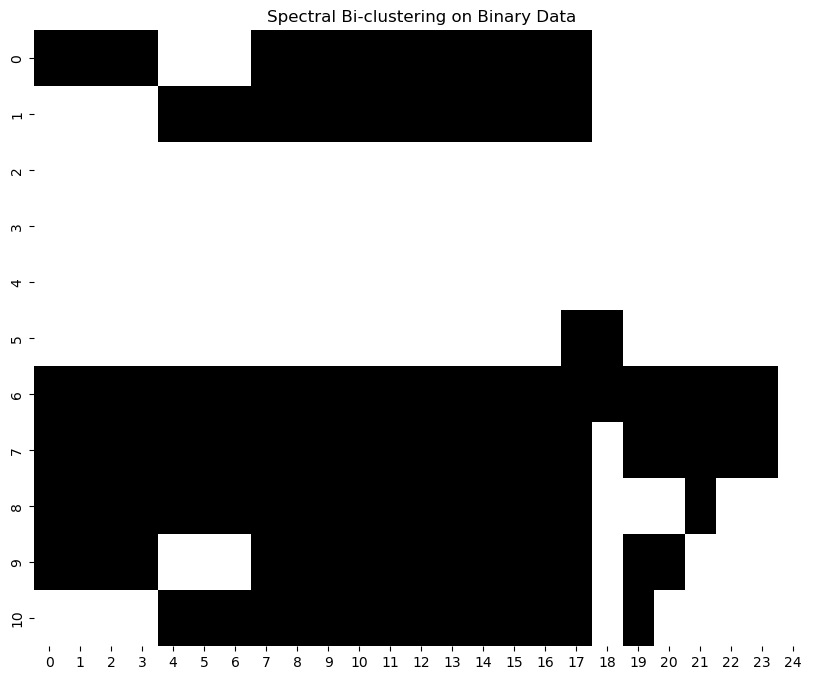

In [21]:
from sklearn.cluster import SpectralBiclustering

def rearrange_matrix_by_spectral_bi_clustering(matrix, n_clusters=2):

    # Step 1: Compute the sum of 1's in each row
    row_sums = np.sum(matrix, axis=1)
    sorted_row_idx_by_ones = np.argsort(-row_sums)
    sorted_matrix = matrix[sorted_row_idx_by_ones, :]

    # Step 2: Sort columns based on the sum of 1's
    col_sums = np.sum(sorted_matrix, axis=0)
    sorted_col_idx_by_ones = np.argsort(-col_sums)
    sorted_matrix = sorted_matrix[:, sorted_col_idx_by_ones]

    # Step 3: Apply Spectral Bi-clustering
    bi_clustering = SpectralBiclustering(n_clusters=n_clusters, random_state=0).fit(sorted_matrix)
    sorted_row_idx_by_clustering = np.argsort(bi_clustering.row_labels_)
    clustered_matrix = sorted_matrix[sorted_row_idx_by_clustering, :]

    sorted_col_idx_by_clustering = np.argsort(bi_clustering.column_labels_)
    clustered_matrix = clustered_matrix[:, sorted_col_idx_by_clustering]

    # Visualize the rearranged matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(clustered_matrix, cmap='Greys', cbar=False)
    plt.title('Spectral Bi-clustering on Binary Data')
    plt.show()

# Example usage
rearrange_matrix_by_spectral_bi_clustering(sorted_data_kmeans, 6)


In [7]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 16.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.0/404.0 kB 31.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
streamlit 1.30.0 requires protobuf<5,>=3.20, but you have protobuf 5.26.1 which is incompatible.


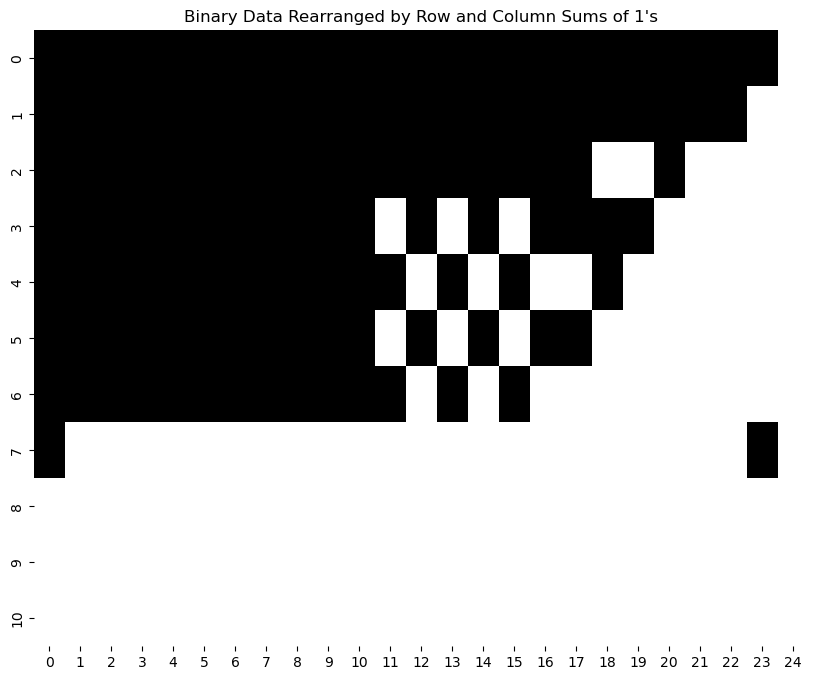

ValueError: too many values to unpack (expected 3)

In [90]:
def rearrange_matrix_by_ones_tsp(matrix):

    # # Step 1: Compute the sum of 1's in each row
    # row_sums = np.sum(matrix, axis=1)  # Sum of 1's per row

    # # Step 2: Sort rows based on the sum of 1's (descending order)
    # sorted_row_idx_by_ones = np.argsort(-row_sums)  # Sort in descending order (more 1's first)

    # # Step 3: Rearrange the matrix rows based on this sorting
    # sorted_matrix = matrix[sorted_row_idx_by_ones, :]

    # Step 4: Compute the sum of 1's in each column of the sorted matrix
    col_sums = np.sum(sorted_matrix, axis=0)  # Sum of 1's per column

    # Step 5: Sort columns based on the sum of 1's (descending order)
    sorted_col_idx_by_ones = np.argsort(-col_sums)  # Sort in descending order (more 1's first)

    # Step 6: Rearrange the sorted matrix columns based on this sorting
    sorted_matrix = sorted_matrix[:, sorted_col_idx_by_ones]

    return sorted_matrix, sorted_row_idx_by_ones, sorted_col_idx_by_ones

clustered_matrix, sorted_row_idx_by_clustering, sorted_col_idx_by_clustering = rearrange_matrix_by_ones(og_transposed_df.values)
new_index = og_transposed_df.index[sorted_row_idx_by_clustering]
new_columns = og_transposed_df.columns[sorted_col_idx_by_clustering]
fit_data = pd.DataFrame(clustered_matrix, columns=new_columns, index=new_index)

In [104]:
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# print(og_transposed_df)
# # Step 1: Compute correlation matrix (14x14 if you have 14 laws)
# correlation_matrix = og_transposed_df.T.corr()
# correlation_matrix = correlation_matrix.fillna(0)
# # print(correlation_matrix)
# # Step 2: Multi-Dimensional Scaling (MDS) to reduce to 2D
# mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
# mds_coords = mds.fit_transform(1 - correlation_matrix)  # using (1 - correlation) as distance


# Define the distance matrix for TSP
# dist_matrix = squareform(pdist(mds_coords))
def solve_tsp(dist_matrix):
    num_points = len(dist_matrix)
    
    # Create the routing index manager and model
    manager = pywrapcp.RoutingIndexManager(num_points, 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    # Define the distance callback
    def distance_callback(from_index, to_index):
        return int(dist_matrix[manager.IndexToNode(from_index)][manager.IndexToNode(to_index)])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting up parameters for TSP
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.seconds = 30

    # Solve the TSP
    solution = routing.SolveWithParameters(search_parameters)

    # Retrieve the path
    if solution:
        path = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            path.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        return path
    else:
        return None

# Step 1: Compute row (law) correlation matrix and apply MDS
row_correlation_matrix = fit_data.T.corr()
row_correlation_matrix = row_correlation_matrix.fillna(0)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
row_mds_coords = mds.fit_transform(1 - row_correlation_matrix)  # Using (1 - correlation) as distance

# Step 2: Solve TSP on rows based on MDS coordinates
row_dist_matrix = squareform(pdist(row_mds_coords))
row_order = solve_tsp(row_dist_matrix)
if row_order:
    tsp_df = fit_data.iloc[row_order]  # Reorder rows
print(row_order)

# # Step 3: Compute column (state) correlation matrix and apply MDS
# col_correlation_matrix = tsp_df.corr()
# col_correlation_matrix = col_correlation_matrix.fillna(0)
# col_mds_coords = mds.fit_transform(1 - col_correlation_matrix)  # Using (1 - correlation) as distance

# # Step 4: Solve TSP on columns based on MDS coordinates
# col_dist_matrix = squareform(pdist(col_mds_coords))
# col_order = solve_tsp(col_dist_matrix)
# if col_order:
#     tsp_df = tsp_df.iloc[:, col_order]  # Reorder columns
# print(col_order)

# print("Optimally Rearranged DataFrame:\n", tsp_df)

[0, 10, 9, 8, 6, 7, 5, 4, 3, 2, 1]


/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


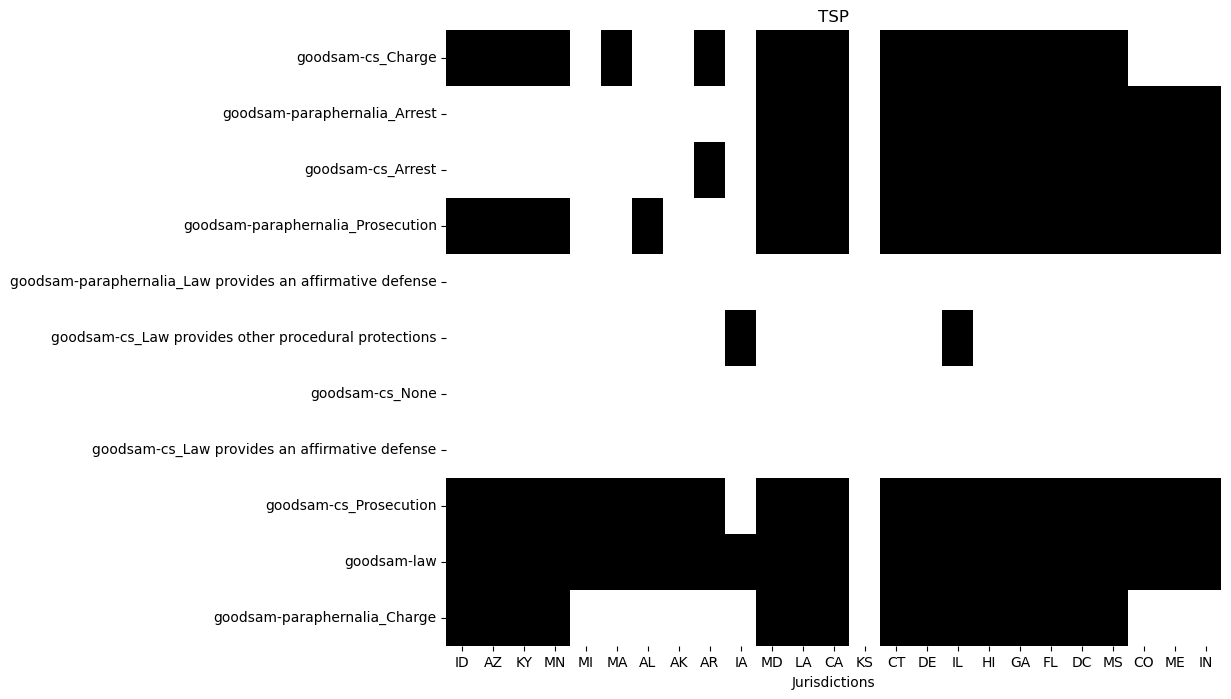

In [106]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(tsp_df, cmap='Greys', cbar=False)
plt.title('TSP')
plt.show()

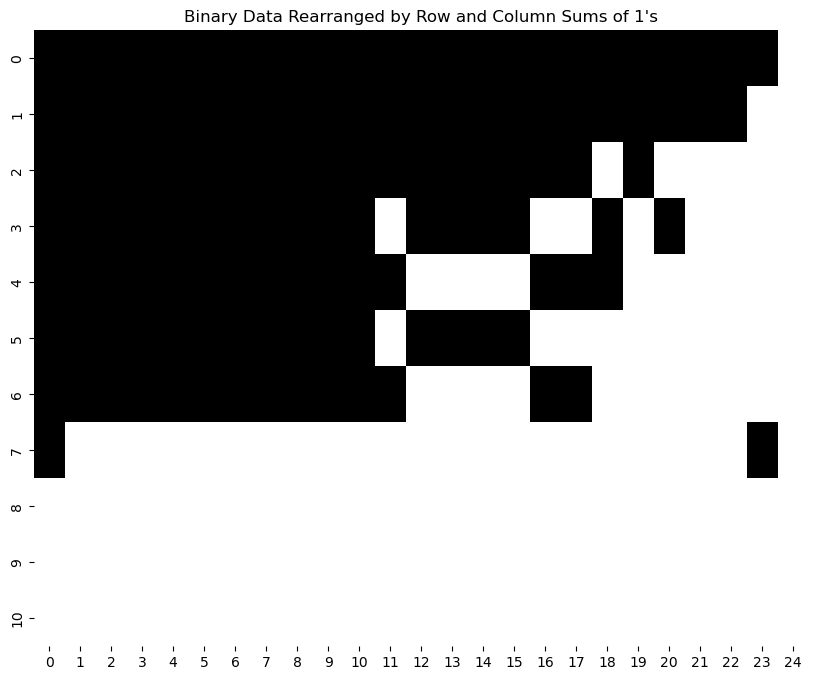

ValueError: too many values to unpack (expected 3)

In [108]:
clustered_matrix, sorted_row_idx_by_clustering, sorted_col_idx_by_clustering = rearrange_matrix_by_ones(tsp_df.values)
new_index = og_transposed_df.index[sorted_row_idx_by_clustering]
new_columns = og_transposed_df.columns[sorted_col_idx_by_clustering]
fit_data = pd.DataFrame(clustered_matrix, columns=new_columns, index=new_index)